In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Flatten,
    Bidirectional, LSTM, GRU, Concatenate, Reshape, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset using the correct lowercase 'date' column
df = pd.read_csv('dataset.csv', parse_dates=['date'])

# Select the 'date' and 'sales' columns
df = df[['date', 'sales']]

# Rename columns to match the paper's convention ('Date', 'Sales')
df.rename(columns={'date': 'Date', 'sales': 'Sales'}, inplace=True)

# Set the new 'Date' column as the index
df.set_index('Date', inplace=True)

# 1. Create 'is_holiday' feature
bd_holidays = holidays.Bangladesh(years=range(2013, 2018))
df['is_holiday'] = df.index.isin(bd_holidays).astype(int)

# 2. Create Cyclic Features
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['year'] = df.index.year

# Apply sin/cos transformations (Eqs. 1-8)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['year_sin'] = np.sin(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))
df['year_cos'] = np.cos(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))

# 3. Final Feature Selection
features_df = df[['Sales', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                  'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_holiday']]

print("Data shape after feature engineering:", features_df.shape)
print(features_df.head())

Data shape after feature engineering: (1826, 10)
            Sales  month_sin  month_cos   day_sin   day_cos  week_sin  \
Date                                                                    
2013-01-01     13        0.5   0.866025  0.201299  0.979530  0.120537   
2013-01-02     11        0.5   0.866025  0.394356  0.918958  0.120537   
2013-01-03     14        0.5   0.866025  0.571268  0.820763  0.120537   
2013-01-04     13        0.5   0.866025  0.724793  0.688967  0.120537   
2013-01-05     10        0.5   0.866025  0.848644  0.528964  0.120537   

            week_cos  year_sin  year_cos  is_holiday  
Date                                                  
2013-01-01  0.992709       0.0       1.0           0  
2013-01-02  0.992709       0.0       1.0           0  
2013-01-03  0.992709       0.0       1.0           0  
2013-01-04  0.992709       0.0       1.0           0  
2013-01-05  0.992709       0.0       1.0           0  


/tmp/ipython-input-2537554181.py:29: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(bd_holidays).astype(int)


In [2]:
# 1. Sequential Data Partitioning (70% train, 20% val, 10% test)
n = len(features_df)
train_df = features_df[0:int(n*0.7)]
val_df = features_df[int(n*0.7):int(n*0.9)]
test_df = features_df[int(n*0.9):]

print(f"\nTrain shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")

# 2. Normalization
target_feature = 'Sales'
other_features = [col for col in features_df.columns if col not in [target_feature, 'is_holiday']]

# Initialize scalers
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit scalers ONLY on training data
target_scaler.fit(train_df[[target_feature]])
feature_scaler.fit(train_df[other_features])

# Function to scale data
def scale_data(df):
    scaled_df = df.copy()
    scaled_df[target_feature] = target_scaler.transform(df[[target_feature]])
    scaled_df[other_features] = feature_scaler.transform(df[other_features])
    return scaled_df

# Transform all datasets
train_scaled = scale_data(train_df)
val_scaled = scale_data(val_df)
test_scaled = scale_data(test_df)

print("\nScaled data example:")
print(train_scaled.head())


Train shape: (1278, 10)
Val shape:   (365, 10)
Test shape:  (183, 10)

Scaled data example:
               Sales  month_sin  month_cos   day_sin   day_cos  week_sin  \
Date                                                                       
2013-01-01 -0.920447   0.594479   1.260508  0.279770  1.424760   0.04202   
2013-01-02 -1.229886   0.594479   1.260508  0.550389  1.338292   0.04202   
2013-01-03 -0.765728   0.594479   1.260508  0.798377  1.198118   0.04202   
2013-01-04 -0.920447   0.594479   1.260508  1.013581  1.009977   0.04202   
2013-01-05 -1.384606   0.594479   1.260508  1.187191  0.781571   0.04202   

            week_cos  year_sin  year_cos  is_holiday  
Date                                                  
2013-01-01   1.40075 -0.222811  1.323135           0  
2013-01-02   1.40075 -0.222811  1.323135           0  
2013-01-03   1.40075 -0.222811  1.323135           0  
2013-01-04   1.40075 -0.222811  1.323135           0  
2013-01-05   1.40075 -0.222811  1.323135    

In [3]:
# Define window parameters
INPUT_WIDTH = 30  # Input sequence length
LABEL_WIDTH = 30  # Output sequence length
SHIFT = 30        # For a single-shot, non-overlapping prediction
LABEL_COLUMNS = [target_feature] # We only predict sales

# Function to create windowed data
def create_windows(data, input_width, label_width, shift):
    X, y = [], []

    for i in range(0, len(data) - input_width - shift + 1):
        input_slice = data.iloc[i : i + input_width].values
        label_slice = data.iloc[i + input_width : i + input_width + shift][LABEL_COLUMNS].values

        # Ensure we have full-length labels
        if len(label_slice) == label_width:
            X.append(input_slice)
            y.append(label_slice)

    return np.array(X), np.array(y)

# Create windowed datasets
X_train, y_train = create_windows(train_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)
X_val, y_val = create_windows(val_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)
X_test, y_test = create_windows(test_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

# Create tf.data.Dataset for efficient training
BATCH_SIZE = 32 #

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


X_train shape: (1219, 30, 10)
y_train shape: (1219, 30, 1)
X_val shape:   (306, 30, 10)
y_val shape:   (306, 30, 1)
X_test shape:  (124, 30, 10)
y_test shape:  (124, 30, 1)


In [4]:
def build_mcdfn_model(input_shape=(INPUT_WIDTH, X_train.shape[2])):
    # Input Layer
    input_tensor = Input(shape=input_shape, name='Input_Layer') #

    # --- Branch 1: CNN ---
    #
    x1 = Conv1D(filters=352, kernel_size=1, activation='relu', name='CNN_Conv1_1')(input_tensor)
    x1 = Conv1D(filters=352, kernel_size=1, activation='relu', name='CNN_Conv1_2')(x1)
    x1 = MaxPooling1D(pool_size=3, name='CNN_MaxPool')(x1) # Inferred from Fig. 8 shape
    x1 = Dense(128, name='CNN_Dense')(x1)
    x1_flat = Flatten(name='CNN_Flatten')(x1)

    # --- Branch 2: BiLSTM ---
    #
    x2 = Bidirectional(LSTM(units=192, name='BiLSTM_Layer'), name='BiLSTM_Bidir')(input_tensor)
    x2_flat = Flatten(name='BiLSTM_Flatten')(x2)

    # --- Branch 3: Bi-GRU ---
    #
    x3 = Bidirectional(GRU(units=64, name='BiGRU_Layer'), name='BiGRU_Bidir')(input_tensor)
    x3_flat = Flatten(name='BiGRU_Flatten')(x3)

    # --- Branch 4: Stacked LSTM ---
    #
    x4 = LSTM(units=64, return_sequences=True, name='Stacked_LSTM_1')(input_tensor)
    x4 = Dropout(0.2, name='Stacked_Dropout_1')(x4)
    x4 = LSTM(units=64, name='Stacked_LSTM_2')(x4)
    x4 = Dropout(0.2, name='Stacked_Dropout_2')(x4)
    x4_flat = Flatten(name='Stacked_Flatten')(x4)

    # --- Fusion ---
    #
    fused = Concatenate(name='Fusion_Layer')([x1_flat, x2_flat, x3_flat, x4_flat])

    # --- Output Head ---
    #
    output = Dense(LABEL_WIDTH, activation='linear', name='Output_Dense')(fused)
    output = Reshape((LABEL_WIDTH, 1), name='Output_Reshape')(output)

    model = Model(inputs=input_tensor, outputs=output, name='MCDFN_Model')
    return model

# Build and summarize the model
mcdfn_model = build_mcdfn_model()
mcdfn_model.summary()

Model: "MCDFN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Conv1_1         │ (None, 30, 352)   │      3,872 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_LSTM_1      │ (None, 30, 64)    │     19,200 │ Input_Layer[0][0] │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Conv1_2         │ (None, 30, 352)   │    124,256 │ CNN_Conv1_1[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Dropout_1   │ (None, 30, 64)    │          0 │ Stacked_LSTM_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_MaxPool         │ (None, 10, 352)   │          0 │ CNN_Conv1_2[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_LSTM_2      │ (None, 64)        │     33,024 │ Stacked_Dropout_… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Dense (Dense)   │ (None, 10, 128)   │     45,184 │ CNN_MaxPool[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Bidir        │ (None, 384)       │    311,808 │ Input_Layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_Bidir         │ (None, 128)       │     29,184 │ Input_Layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Dropout_2   │ (None, 64)        │          0 │ Stacked_LSTM_2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Flatten         │ (None, 1280)      │          0 │ CNN_Dense[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Flatten      │ (None, 384)       │          0 │ BiLSTM_Bidir[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_Flatten       │ (None, 128)       │          0 │ BiGRU_Bidir[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Flatten     │ (None, 64)        │          0 │ Stacked_Dropout_… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fusion_Layer        │ (None, 1856)      │          0 │ CNN_Flatten[0][0… │
│ (Concatenate)       │                   │            │ BiLSTM_Flatten[0… │
│                     │                   │            │ BiGRU_Flatten[0]… │
│                     │                   │            │ Stacked_Flatten[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 622,238 (2.37 MB)

 Trainable params: 622,238 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compile the model
mcdfn_model.compile(optimizer='adam', #
                    loss='mse')       #

# Define EarlyStopping callback (CORRECTED LINE)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True) # Was 'restore__weights'

# Train the model
history = mcdfn_model.fit(
    train_dataset,
    epochs=50, #
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Save the model in the .keras format
mcdfn_model.save('mcdfn_model.keras')
print("\nModel saved as 'mcdfn_model.keras'.")

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.7613 - val_loss: 0.8561
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7995 - val_loss: 0.8120
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6590 - val_loss: 0.8688
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5869 - val_loss: 0.7400
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5602 - val_loss: 0.8053
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5343 - val_loss: 0.8190
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5450 - val_loss: 0.9455
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5421 - val_loss: 0.9589
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5492 - val_loss: 0.7757
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5449 - val_loss: 0.9187
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5260 - val_loss: 0.7091
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5

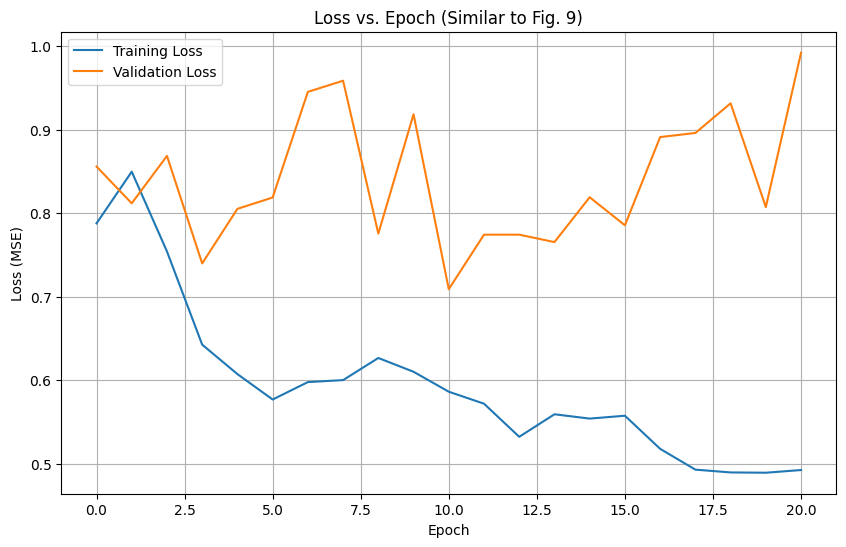

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
--- Test Set Evaluation Metrics ---
Test MSE:   35.6775
Test RMSE:  5.9731
Test MAE:   4.8289
Test MAPE:  23.15%


In [6]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch (Similar to Fig. 9)') #
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions on the test set
predictions_scaled = mcdfn_model.predict(test_dataset)

# Reshape for inverse scaling
pred_shape = predictions_scaled.shape
true_shape = y_test.shape
predictions_scaled_flat = predictions_scaled.reshape(pred_shape[0] * pred_shape[1], 1)
y_test_flat = y_test.reshape(true_shape[0] * true_shape[1], 1)

# Inverse transform to original sales values
predictions_unscaled = target_scaler.inverse_transform(predictions_scaled_flat)
y_test_unscaled = target_scaler.inverse_transform(y_test_flat)

# Calculate final metrics
mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled)

print("--- Test Set Evaluation Metrics ---")
print(f"Test MSE:   {mse:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test MAE:   {mae:.4f}")
print(f"Test MAPE:  {mape*100:.2f}%")

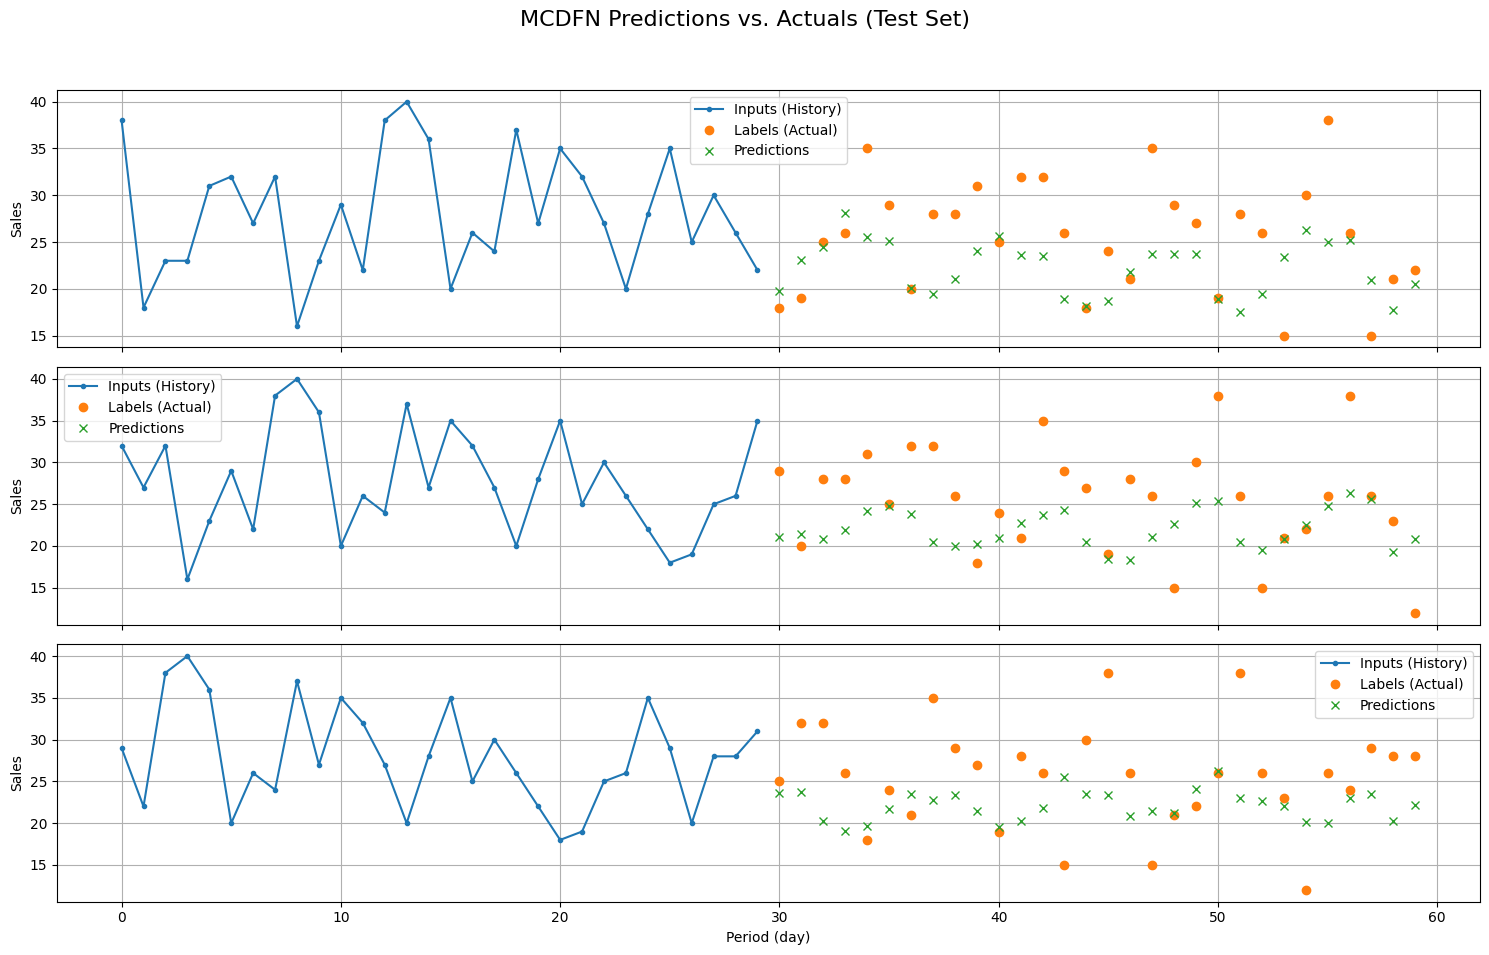

In [7]:
# Reshape predictions back to (windows, 30, 1) for easier plotting
predictions_unscaled_windows = predictions_unscaled.reshape(pred_shape)
y_test_unscaled_windows = y_test_unscaled.reshape(true_shape)
X_test_sales_unscaled = target_scaler.inverse_transform(X_test[:, :, 0])

# Plot 3 example windows
plot_indices = [0, 5, 10]
fig, axes = plt.subplots(len(plot_indices), 1, figsize=(15, 10), sharex=True)
fig.suptitle('MCDFN Predictions vs. Actuals (Test Set)', fontsize=16)

for i, idx in enumerate(plot_indices):
    if idx >= len(X_test_sales_unscaled):
        continue
    ax = axes[i]
    input_days = np.arange(0, INPUT_WIDTH)
    ax.plot(input_days, X_test_sales_unscaled[idx, :], label='Inputs (History)', marker='.')
    label_days = np.arange(INPUT_WIDTH, INPUT_WIDTH + LABEL_WIDTH)
    ax.plot(label_days, y_test_unscaled_windows[idx, :, 0], label='Labels (Actual)', marker='o', linestyle='None')
    ax.plot(label_days, predictions_unscaled_windows[idx, :, 0], label='Predictions', marker='x', linestyle='None')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Period (day)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Predicting using data from 2016-07-02 00:00:00 to 2016-07-31 00:00:00 ---


/tmp/ipython-input-2134218662.py:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_slice['is_holiday'] = df_slice.index.isin(bd_holidays).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step

--- 30-Day Sales Forecast ---
[23.58 26.18 25.89 27.78 28.21 28.69 27.2  22.97 24.03 25.26 26.39 25.72
 26.94 27.48 24.2  23.36 23.22 25.03 26.94 27.76 27.05 23.25 22.93 24.37
 27.82 28.2  30.57 28.85 22.34 24.43]

--- Comparison ---


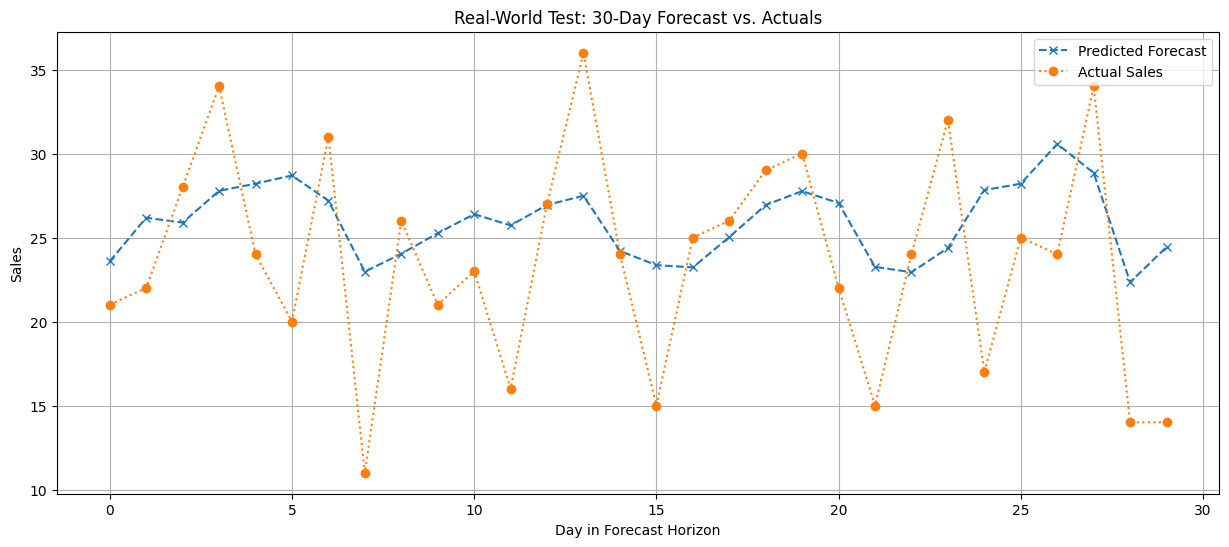

In [8]:
# --- 1. Load the saved model ---
# from tensorflow.keras.models import load_model
# model = load_model('mcdfn_model.keras')
# NOTE: We can just use 'mcdfn_model' since it's already in memory

# --- 2. Get 30 days of raw data ---
# We'll take the first 30 days of the validation set as an example
start_idx = int(n * 0.7) # Start of validation set
end_idx = start_idx + INPUT_WIDTH # Get 30 days
raw_input_data = pd.read_csv('dataset.csv', parse_dates=['date']).iloc[start_idx:end_idx]

# We also get the *actual* next 30 days to compare our forecast
actual_next_30_days = pd.read_csv('dataset.csv').iloc[end_idx : end_idx + LABEL_WIDTH]

print(f"--- Predicting using data from {raw_input_data['date'].min()} to {raw_input_data['date'].max()} ---")

# --- 3. Preprocess the raw data ---
# This function MUST be identical to the preprocessing in Step 1
def preprocess_new_data(df_slice):
    df_slice = df_slice.copy()
    df_slice.set_index('date', inplace=True)
    df_slice['is_holiday'] = df_slice.index.isin(bd_holidays).astype(int)
    df_slice['month'] = df_slice.index.month
    df_slice['day_of_month'] = df_slice.index.day
    df_slice['week_of_year'] = df_slice.index.isocalendar().week
    df_slice['year'] = df_slice.index.year
    df_slice['month_sin'] = np.sin(2 * np.pi * df_slice['month'] / 12)
    df_slice['month_cos'] = np.cos(2 * np.pi * df_slice['month'] / 12)
    df_slice['day_sin'] = np.sin(2 * np.pi * df_slice['day_of_month'] / 31)
    df_slice['day_cos'] = np.cos(2 * np.pi * df_slice['day_of_month'] / 31)
    df_slice['week_sin'] = np.sin(2 * np.pi * df_slice['week_of_year'] / 52)
    df_slice['week_cos'] = np.cos(2 * np.pi * df_slice['week_of_year'] / 52)
    df_slice['year_sin'] = np.sin(2 * np.pi * (df_slice['year'] - 2013) / (2017 - 2013)) # Use same range as training
    df_slice['year_cos'] = np.cos(2 * np.pi * (df_slice['year'] - 2013) / (2017 - 2013))
    # Rename 'sales' to 'Sales' and ensure correct column order
    df_slice.rename(columns={'sales': 'Sales'}, inplace=True)
    return df_slice[features_df.columns] # Return in the same order as training

processed_input = preprocess_new_data(raw_input_data)

# --- 4. Scale the data using *fitted* scalers ---
# DO NOT .fit() again, only .transform()
scaled_input = processed_input.copy()
scaled_input[target_feature] = target_scaler.transform(processed_input[[target_feature]])
scaled_input[other_features] = feature_scaler.transform(processed_input[other_features])

# --- 5. Reshape for the model ---
# Model expects (batch_size, timesteps, features)
model_input = np.array(scaled_input).reshape(1, INPUT_WIDTH, 10) # 1 sample, 30 days, 10 features

# --- 6. Predict ---
scaled_prediction = mcdfn_model.predict(model_input)

# --- 7. Inverse transform the prediction ---
# Reshape for scaler: (30, 1)
scaled_prediction_flat = scaled_prediction.reshape(LABEL_WIDTH, 1)
final_forecast = target_scaler.inverse_transform(scaled_prediction_flat)

# --- 8. View the results ---
print("\n--- 30-Day Sales Forecast ---")
print(final_forecast.flatten().round(2))

print("\n--- Comparison ---")
plt.figure(figsize=(15, 6))
plt.plot(np.arange(30), final_forecast, label='Predicted Forecast', marker='x', linestyle='--')
plt.plot(np.arange(30), actual_next_30_days['sales'].values, label='Actual Sales', marker='o', linestyle=':')
plt.title('Real-World Test: 30-Day Forecast vs. Actuals')
plt.xlabel('Day in Forecast Horizon')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Calculating baseline score on test data...
Baseline Score (Negative MSE): -35.6775
Baseline calculation time: 0.51 seconds

Calculating Manual Permutation Feature Importance...
  Permuting feature: Sales (1/10)...
  Permuting feature: month_sin (2/10)...
  Permuting feature: month_cos (3/10)...
  Permuting feature: day_sin (4/10)...
  Permuting feature: day_cos (5/10)...
  Permuting feature: week_sin (6/10)...
  Permuting feature: week_cos (7/10)...
  Permuting feature: year_sin (8/10)...
  Permuting feature: year_cos (9/10)...
  Permuting feature: is_holiday (10/10)...
Manual PFI calculation finished in 5.20 seconds.

--- Manual Permutation Feature Importance (Mean Decrease in Score [-MSE]) ---
Sales         7.779099
month_cos     1.438997
week_cos      1.102377
month_sin     0.240333
week_sin      0.187712
is_holiday    0.031110
year_sin      0.000000
year_cos      0.000000
day_sin      -0.577679
day_cos      -1.902242
dtype: float64

Saved Manual PFI plot as 'pfi_manual_importance.p

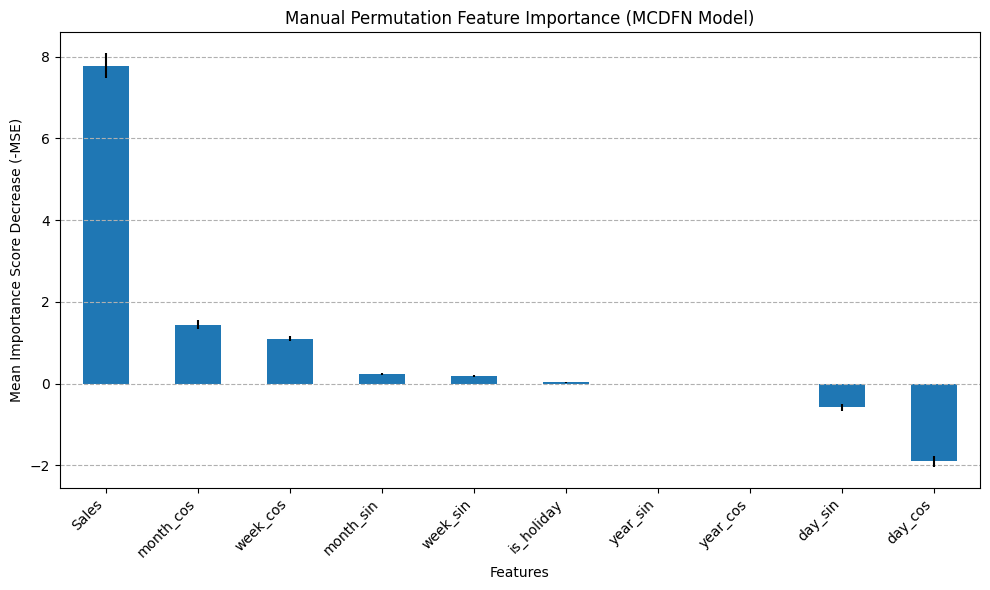

In [9]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from collections import defaultdict

# --- (Keep the pfi_scorer function from the previous step) ---
# --- 1. Define Custom Scorer ---
def pfi_scorer(model, X_perm, y_true_scaled):
    scaled_preds = model.predict(X_perm, batch_size=BATCH_SIZE, verbose=0)
    pred_shape = scaled_preds.shape
    true_shape = y_true_scaled.shape
    preds_flat = scaled_preds.reshape(pred_shape[0] * pred_shape[1], 1)
    y_true_flat = y_true_scaled.reshape(true_shape[0] * true_shape[1], 1)
    preds_unscaled = target_scaler.inverse_transform(preds_flat)
    y_true_unscaled = target_scaler.inverse_transform(y_true_flat)
    mse = mean_squared_error(y_true_unscaled, preds_unscaled)
    return -mse # Negative MSE

# --- 2. Calculate Baseline Score ---
print("Calculating baseline score on test data...")
start_baseline = time.time()
baseline_score = pfi_scorer(mcdfn_model, X_test, y_test)
print(f"Baseline Score (Negative MSE): {baseline_score:.4f}")
print(f"Baseline calculation time: {time.time() - start_baseline:.2f} seconds")

# --- 3. Manual Permutation Importance Calculation ---
print("\nCalculating Manual Permutation Feature Importance...")
start_pfi = time.time()

n_repeats = 5 # Number of times to shuffle each feature
rng = np.random.RandomState(42) # For reproducible shuffling
permuted_scores = defaultdict(list) # Dictionary to store scores for each feature

# Ensure feature_names is defined (from features_df in cell 1)
feature_names = features_df.columns.tolist()
n_features = X_test.shape[2] # Should be 10

for i in range(n_features): # Loop through each feature index (0 to 9)
    feature_name = feature_names[i]
    print(f"  Permuting feature: {feature_name} ({i+1}/{n_features})...")

    for _ in range(n_repeats): # Repeat shuffling n_repeats times
        X_test_permuted = X_test.copy()

        # --- Correct Shuffling for 3D Data ---
        # Get the feature data across all samples and time steps
        feature_data = X_test_permuted[:, :, i].flatten()
        # Shuffle this flattened data
        rng.shuffle(feature_data)
        # Reshape it back and assign it to the permuted array
        X_test_permuted[:, :, i] = feature_data.reshape(X_test.shape[0], X_test.shape[1])
        # ----------------------------------------

        # Calculate score with the permuted feature
        score = pfi_scorer(mcdfn_model, X_test_permuted, y_test)
        permuted_scores[feature_name].append(score)

print(f"Manual PFI calculation finished in {time.time() - start_pfi:.2f} seconds.")

# --- 4. Calculate Importance Scores ---
importances_mean = {}
importances_std = {}

print("\n--- Manual Permutation Feature Importance (Mean Decrease in Score [-MSE]) ---")
for feature_name in feature_names:
    scores = np.array(permuted_scores[feature_name])
    importance_mean = baseline_score - np.mean(scores) # Baseline - Permuted = Drop
    importance_std = np.std(scores)
    importances_mean[feature_name] = importance_mean
    importances_std[feature_name] = importance_std
    # print(f"  {feature_name}: Mean={importance_mean:.4f}, Std={importance_std:.4f}") # Optional detail

# Sort by importance
pfi_manual_importances = pd.Series(importances_mean).sort_values(ascending=False)
pfi_manual_std = pd.Series(importances_std)

print(pfi_manual_importances)

# --- 5. Plot Results ---
plt.figure(figsize=(10, 6))
pfi_manual_importances.plot(kind='bar', yerr=pfi_manual_std[pfi_manual_importances.index])
plt.title('Manual Permutation Feature Importance (MCDFN Model)')
plt.ylabel('Mean Importance Score Decrease (-MSE)') # Positive value = performance dropped
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('pfi_manual_importance.png')
print("\nSaved Manual PFI plot as 'pfi_manual_importance.png'")

In [13]:
## 🧪 SHAP Implementation (Manual Single-Step - KernelExplainer Fallback with Reshaping)

import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# --- 1. Ensure Eager Execution is Enabled ---
print(f"TensorFlow Eager Execution enabled: {tf.executing_eagerly()}")

# --- 2. Define Output Step to Explain ---
output_step_to_explain = 0 # 0 for the first day
print(f"--- Explaining Forecast for Day {output_step_to_explain + 1} using KernelExplainer ---")

# --- 3. Create/Retrieve the Single Output Step Model ---
print("Creating/Retrieving single-step model...")
# (Using the same logic as before to create or reuse model_single_step)
try:
    model_single_step = tf.keras.models.Model(
        inputs=mcdfn_model.input,
        outputs=mcdfn_model.get_layer(f'squeeze_step_{output_step_to_explain}').output
    )
    print("Using existing single-step model architecture.")
except Exception:
    input_tensor = mcdfn_model.input
    output_tensor_sliced = tf.keras.layers.Lambda(
        lambda x: x[:, output_step_to_explain:output_step_to_explain+1, :],
        name=f'slice_step_{output_step_to_explain}'
    )(mcdfn_model.output)
    output_tensor_squeezed = tf.keras.layers.Lambda(
        lambda x: tf.squeeze(x, axis=1),
        name=f'squeeze_step_{output_step_to_explain}'
    )(output_tensor_sliced)
    model_single_step = tf.keras.models.Model(
        inputs=input_tensor,
        outputs=output_tensor_squeezed,
        name=f'MCDFN_Step_{output_step_to_explain}'
    )
    print("Created new single-step model architecture.")

# --- 4. Get Data Dimensions ---
# Get dimensions BEFORE flattening
n_samples_train, n_timesteps, n_features = X_train.shape

# --- 5. Define Prediction Function for KernelExplainer ---
# KernelExplainer needs a function that takes a 2D numpy array (samples, features_flat)
# and returns a 1D numpy array (samples,) or 2D (samples, 1).
# We use the dimensions captured above (n_timesteps, n_features) for reshaping.
def predict_fn_kernel(X_flat):
    num_samples = X_flat.shape[0]
    # Reshape back to 3D: (num_perturbations, n_timesteps, n_features)
    X_reshaped = X_flat.reshape(num_samples, n_timesteps, n_features)
    # Predict using the single-step model
    predictions = model_single_step.predict(X_reshaped, batch_size=BATCH_SIZE, verbose=0)
    return predictions.flatten() # Flatten output to (num_samples,)

# --- 6. Select Background Data & Summarize (with Reshaping) ---
print("Selecting and summarizing background data for SHAP KernelExplainer...")
background_data_summary_flat = None
try:
    # *** Reshape X_train to 2D for kmeans ***
    X_train_flat = X_train.reshape(n_samples_train, n_timesteps * n_features)
    print(f"Reshaped X_train to {X_train_flat.shape} for kmeans.")

    # Attempt kmeans summarization on the flattened data
    # The result (background_data_summary_obj.data) will be 2D
    background_data_summary_obj = shap.kmeans(X_train_flat, 10) # Summarize into 10 centers
    background_data_summary_flat = background_data_summary_obj.data
    print(f"Summarized background data (flat) shape: {background_data_summary_flat.shape}")

except Exception as e:
    # Fallback to sampling if kmeans fails
    print(f"KMeans summarization failed ({e}), using random sampling (less optimal)...")
    n_bg_samples = 25 # Use fewer samples for background with KernelExplainer
    indices = np.random.choice(X_train.shape[0], n_bg_samples, replace=False)
    background_data_sample = X_train[indices]
    # *** Reshape the sampled background data to 2D ***
    background_data_summary_flat = background_data_sample.reshape(n_bg_samples, n_timesteps * n_features)
    print(f"Sampled and flattened background data shape: {background_data_summary_flat.shape}")


# --- 7. Create SHAP KernelExplainer ---
print("\nCreating SHAP KernelExplainer...")
start_explainer = time.time()
explainer_single_step = None
explainer_type = "None"
if background_data_summary_flat is not None:
    try:
        # KernelExplainer expects the 2D flattened background data
        explainer_single_step = shap.KernelExplainer(predict_fn_kernel, background_data_summary_flat)
        print(f"KernelExplainer created in {time.time() - start_explainer:.2f} seconds.")
        explainer_type = "KernelExplainer"
    except Exception as e:
        print(f"KernelExplainer creation failed: {e}. SHAP analysis aborted.")
else:
    print("Background data summarization failed. SHAP analysis aborted.")


# --- 8. Calculate SHAP Values (if explainer was created) ---
# WARNING: This step will be VERY SLOW with KernelExplainer!
shap_values_single_step = None
if explainer_single_step:
    print("\nCalculating SHAP values using KernelExplainer (THIS WILL BE VERY SLOW)...")
    start_shap_calc = time.time()
    # Use a small subset of test data
    n_explain_samples = 5 # *** Explain only 5 samples for demonstration ***
    X_test_subset = X_test[:n_explain_samples]
    print(f"Explaining {n_explain_samples} test samples...")

    # *** Reshape the 3D test subset to 2D for KernelExplainer ***
    X_test_subset_flat = X_test_subset.reshape(n_explain_samples, n_timesteps * n_features)

    try:
        # Pass the flattened test data
        shap_values_flat = explainer_single_step.shap_values(X_test_subset_flat, nsamples='auto') # nsamples='auto' or set a number like 50
        print(f"SHAP values calculated in {time.time() - start_shap_calc:.2f} seconds.")
        # Reshape SHAP values back to (samples, timesteps, features)
        shap_values_array = shap_values_flat.reshape(n_explain_samples, n_timesteps, n_features)
        print(f"Reshaped SHAP values array shape: {shap_values_array.shape}")
        shap_values_single_step = [shap_values_array] # Keep list structure
    except Exception as e:
        print(f"Calculating SHAP values failed: {e}")
        shap_values_single_step = None

# --- 9. Visualize SHAP Values (if calculated) ---
if shap_values_single_step is not None:
    print("\nGenerating SHAP summary plots...")

    if 'features_df' in locals():
        feature_names = features_df.columns.tolist()
    else:
        print("Warning: 'features_df' not found. Using generic feature names.")
        feature_names = [f'feature_{i}' for i in range(n_features)]

    # Average absolute SHAP values across the time dimension
    shap_values_avg_time = np.mean(np.abs(shap_values_array), axis=1)

    # Average input features across time for dot plot coloring
    # Use the original 3D X_test_subset here
    X_test_subset_avg_time = pd.DataFrame(X_test_subset.mean(axis=1), columns=feature_names)

    # Create and save Bar plot
    try:
        plt.figure()
        shap.summary_plot(
            shap_values_avg_time,
            X_test_subset_avg_time,
            feature_names=feature_names,
            plot_type="bar",
            show=False
        )
        plt.title(f'Mean Absolute SHAP Value (Day {output_step_to_explain+1} Fcst - {explainer_type})')
        plt.tight_layout()
        plt.savefig(f'shap_{explainer_type.lower()}_bar_step_{output_step_to_explain}.png')
        print(f"Saved SHAP bar plot as 'shap_{explainer_type.lower()}_bar_step_{output_step_to_explain}.png'")
        plt.close()
    except Exception as e:
        print(f"Failed to generate/save bar plot: {e}")

    # Create and save Dot plot
    try:
        plt.figure()
        shap.summary_plot(
            shap_values_avg_time,
            X_test_subset_avg_time,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'SHAP Value Distribution (Day {output_step_to_explain+1} Fcst - {explainer_type})')
        plt.tight_layout()
        plt.savefig(f'shap_{explainer_type.lower()}_dot_step_{output_step_to_explain}.png')
        print(f"Saved SHAP dot plot as 'shap_{explainer_type.lower()}_dot_step_{output_step_to_explain}.png'")
        plt.close()
    except Exception as e:
        print(f"Failed to generate/save dot plot: {e}")
else:
    print("\nSHAP analysis could not be completed.")

print(f"\nManual SHAP analysis attempt using {explainer_type} for Day {output_step_to_explain + 1} finished.")

TensorFlow Eager Execution enabled: True
--- Explaining Forecast for Day 1 using KernelExplainer ---
Creating/Retrieving single-step model...
Created new single-step model architecture.
Selecting and summarizing background data for SHAP KernelExplainer...
Reshaped X_train to (1219, 300) for kmeans.
Summarized background data (flat) shape: (10, 300)

Creating SHAP KernelExplainer...
KernelExplainer created in 0.53 seconds.

Calculating SHAP values using KernelExplainer (THIS WILL BE VERY SLOW)...
Explaining 5 test samples...


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP values calculated in 25.11 seconds.
Reshaped SHAP values array shape: (5, 30, 10)

Generating SHAP summary plots...
Saved SHAP bar plot as 'shap_kernelexplainer_bar_step_0.png'
Saved SHAP dot plot as 'shap_kernelexplainer_dot_step_0.png'

Manual SHAP analysis attempt using KernelExplainer for Day 1 finished.
